In [1]:
from matplotlib import pyplot as plt
import numpy as np
import time

from moist_euler_dg.fortran_three_phase_euler_2D import FortranThreePhaseEuler2D

In [2]:
# test case parameters
domain_width = 10_000 # width of domain in metres
domain_height = 10_000 # height of domain in metres

p_surface = 1_00_000.0 # surface pressure in Pa
SST = 300.0 # sea surface temperature in Kelvin

cooling_rate = 10.0 / (3600 * 24) # cools 10 K per day

In [3]:
# forcing - this adds uniform cooling to air
# and forces the bottom temperature to match the SST
def cooling_and_sst_forcing(solver, state, dstatedt):
    u, w, h, s, q, T, mu, p, ie = solver.get_vars(state)
    dudt, dwdt, dhdt, dsdt, dqdt, *_ = solver.get_vars(dstatedt)

    # internal cooling
    T_forcing = -cooling_rate * solver.zs / solver.zs.max() # constantly cool at a rate of 1K per day
    s_forcing = T_forcing * solver.cvd / T # convert temperature forcing to entropy forcing

    # boundary forcing at bottom - force bottom temperature  towards SST
    bottom_bdry_idx = solver.ip_vert_ext
    s_forcing[bottom_bdry_idx] = 0.0
    T_forcing = -(T[bottom_bdry_idx] - SST) / 60 # 1 mins relaxation time
    s_forcing[bottom_bdry_idx] += T_forcing * solver.cvd / T[bottom_bdry_idx]

    dsdt += s_forcing

In [4]:
# model parameters
nz = 32 # number of cells in vertical direction
nx = 32 # number of cells in horizontal direction
polynomial_order = 3 # order or polynomials in each cell


# note: horizontal resolution dx = width / (nx * polynomial_order),
# vertical resolution dz = height / (nz * polynomial_order)

# other parameters that probably don't need to be changed
g = 9.81 # gravitational acceleration
upwind = True # whether to use upwind fluxes for moisture and entropy transport
a = 0.5 # kinetic energy dissipation parameter
cfl = 0.5 # sets the CFL number of the time step, dt = CFL * speed of sound / min(dx, dz)

In [5]:
# construct solver
# maps [0, 1]^2 to domain - can be used to create curved meshes
# this just creates a rectangular grid
zmap = lambda x, z: z * domain_height
xmap = lambda x, z: domain_width * (x - 0.5)

# create a really small examples solver with 2 horixzontal cells and 3 vertical cells
solver = FortranThreePhaseEuler2D(
    xmap, zmap, polynomial_order, nx=nx, nz=nz, g=9.81, cfl=0.5, a=0.5, upwind=upwind,
    forcing=cooling_and_sst_forcing
)

### Solver variables

- T: temperature
- p: pressure
- s: specific entropy
- h: density
- q/qw: water mass fraction
- qv: water vapour mass fraction
- ql: liquid water mass fraction
- qi: ice mass fraction
- u: horizontal air velocity
- w: vertical air velocity

In [6]:
def neutrally_stable_dry_profile(solver):
    # create a hydrostatically balanced pressure and density profile
    dexdy = -g / (solver.cpd * SST)
    ex = 1 + dexdy * solver.zs
    p = p_surface * ex ** (solver.cpd / solver.Rd)
    density = p / (solver.Rd * ex * SST)
    
    return density, p

    

def initial_condition(solver):
    # initial wind is zero
    u = np.zeros_like(solver.xs)
    w = np.zeros_like(solver.xs)
    
    density, p = neutrally_stable_dry_profile(solver)
    
    # add arbitrary moisute profile
    qw = solver.rh_to_qw(0.95, p, density) # choose 95% relative humidity
    
    # model must be initialized with entropy not temperature
    # so convert density, pressure, qw profile to a density, entropy, qw profile
    s = solver.entropy(density, qw, p=p)
    
    # can also do s = solver.entropy(density, qw, T=T) to use temperature profiles
    
    return u, w, density, s, qw

In [7]:
# intialize solver
u, w, density, s, qw = initial_condition(solver)
np.random.seed(42)
noise = 2 * (np.random.random(density.shape) - 0.5)
density += 0.01 * density * noise

solver.set_initial_condition(u, w, density, s, qw)
solver.time = 0

E0 = solver.energy()
entropy_var_0 = solver.integrate(solver.h * solver.s**2)
water_var_0 = solver.integrate(solver.h * solver.q**2)

In [8]:
# inspecting variables

print('Temperature range:', solver.T.min(), solver.T.max())
print('Pressure range:', solver.p.min(), solver.p.max())
print('Density range:', solver.h.min(), solver.h.max())
print('Entropy range:', solver.s.min(), solver.s.max())
print('Water fraction range:', solver.q.min(), solver.q.max())
print('Water vapour fraction range:', solver.qv.min(), solver.qv.max())
print('Liquid water fraction range:', solver.ql.min(), solver.ql.max())

Temperature range: 201.49416057888885 299.6759733381922
Pressure range: 24848.18824476733 101378.46704165451
Density range: 0.42968349904289116 1.1728614666757895
Entropy range: 2422.4797180648284 2498.9385116010667
Water fraction range: 7.386642278473904e-06 0.008243762506076892
Water vapour fraction range: 7.023058902130993e-06 0.008243762506076892
Liquid water fraction range: 0.0 0.0


In [9]:
# run the simulation!
tend = 4000 # simulation end time in seconds

t0 = time.time()
while solver.time < tend:
    solver.time_step()

t1 = time.time()

print(f'Wall time: {t1 - t0}s')
print(f'Model time: {solver.time}s')

Wall time: 367.5027959346771s
Model time: 4000.0802965320026s


In [10]:
# print(solver.integrate(dE) / E0)
E1 = solver.energy()
print('Relative Energy growth:', (E1 - E0) / E0)

entropy_var_1 = solver.integrate(solver.h * solver.s**2)
print('Relative entropy var growth:', (entropy_var_1 - entropy_var_0) / entropy_var_0)

water_var_1 = solver.integrate(solver.h * solver.q**2)
print('Relative water var growth:', (water_var_1 - water_var_0) / water_var_0)

Relative Energy growth: -0.0008642892412595584
Relative entropy var growth: -0.00044705295289163493
Relative water var growth: -0.39133864007063757


In [11]:
# save basic profile for plotting below
_, _, density0, s0, qw0 = initial_condition(solver)
qv0, ql0, qi0 = solver.solve_fractions_from_entropy(density0, qw0, s0)

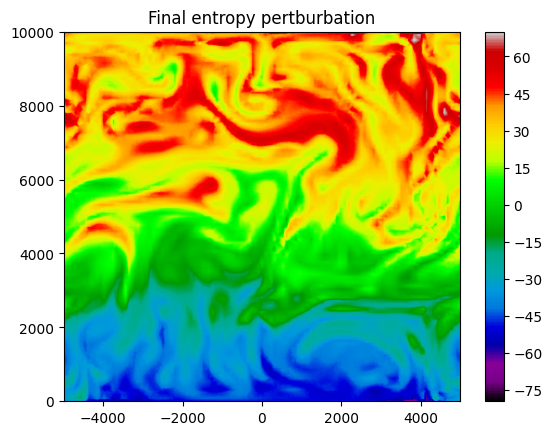

In [12]:
plt.title('Final entropy pertburbation')
plt.tricontourf(
    solver.xs.ravel(), solver.zs.ravel(), solver.project_H1(solver.s).ravel() - s0.ravel(), levels=1000, cmap='nipy_spectral'
)
plt.colorbar()
plt.show()

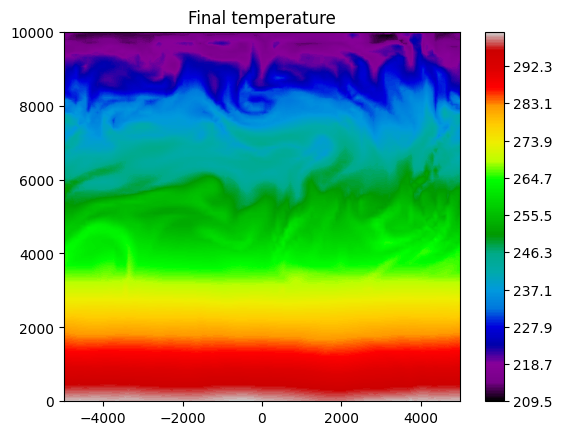

In [13]:
plt.title('Final temperature')
plt.tricontourf(
    solver.xs.ravel(), solver.zs.ravel(), solver.project_H1(solver.T).ravel(), levels=1000, cmap='nipy_spectral'
)
plt.colorbar()
plt.show()

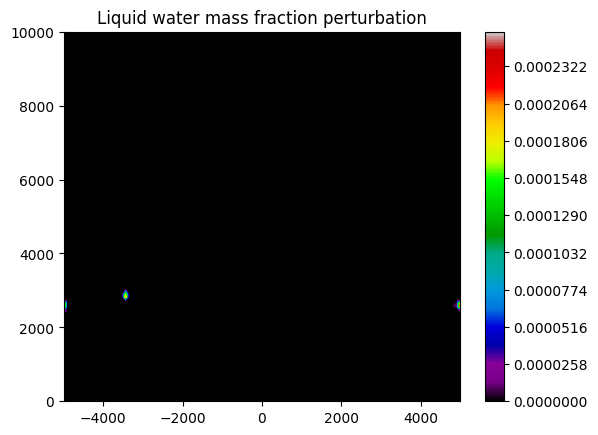

In [14]:
plt.title('Liquid water mass fraction perturbation')
plt.tricontourf(
    solver.xs.ravel(), solver.zs.ravel(), solver.project_H1(solver.ql - ql0).ravel(), levels=1000, cmap='nipy_spectral'
)
plt.colorbar()
plt.show()

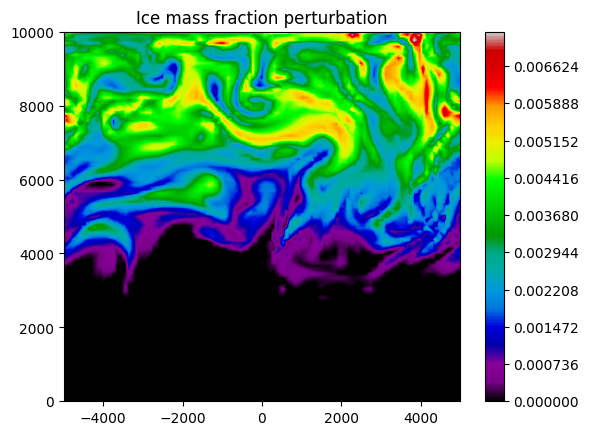

In [15]:
plt.title('Ice mass fraction perturbation')
plt.tricontourf(
    solver.xs.ravel(), solver.zs.ravel(), solver.project_H1(solver.qi - qi0).ravel(), levels=1000, cmap='nipy_spectral'
)
plt.colorbar()
plt.show()